# **Setup**

In [109]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split



#**Get Dataset from Kaggle**

In [16]:
!pip install kaggle


  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=4147513846c64782fb46b56b653447c74c4f0271756b5055de95c1ce168cab13
  Stored in directory: /Users/virinchiv/Library/Caches/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [36]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json  # Change file permissions
os.environ['KAGGLE_USERNAME'] = "virinchiv"
os.environ['KAGGLE_KEY'] = "0b9dd7658766f0ac5ebb17d0de3348b1"

kaggle.json


In [38]:
!kaggle competitions download -c ieee-fraud-detection

100%|███████████████████████████████████████▉| 118M/118M [00:43<00:00, 5.26MB/s]
100%|████████████████████████████████████████| 118M/118M [00:43<00:00, 2.88MB/s]


In [40]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile('ieee-fraud-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('ieee_fraud_data')

# List files to confirm extraction
os.listdir('ieee_fraud_data')


['test_transaction.csv',
 'train_identity.csv',
 'test_identity.csv',
 'sample_submission.csv',
 'train_transaction.csv']

#**Create Pandas DataFrame for Dataset**

In [42]:
# Load the dataset
train_transaction = pd.read_csv('ieee_fraud_data/train_transaction.csv')
train_identity = pd.read_csv('ieee_fraud_data/train_identity.csv')



In [43]:
# Display the first few rows
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# Merge transaction and identity datasets on 'TransactionID'
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Display the merged dataframe
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


#**Handling Duplicates and Null Values**

In [78]:
# Remove null values from all columns except 'Time'
# train_df = train_df[train_df.columns.difference(['Time'])].dropna().join(train_df['Time'])

# Confirm the result
print("Remaining null values in the dataset:")
print(train_df.isnull().sum())


Remaining null values in the dataset:
TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64


In [79]:
train_df.duplicated().sum() #

0

In [81]:
train_df.drop_duplicates(inplace=True) #drop all duplicates

In [84]:
threshold = 0.8
train_df = train_df[train_df.columns[train_df.isnull().mean() < threshold]]
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [86]:
for col in train_df.columns:
    if train_df[col].dtype in ['float64', 'int64']:
        train_df[col].fillna(train_df[col].median(), inplace=True)
    else:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)

# Drop columns that are irrelevant or have high cardinality (e.g., TransactionID, DeviceInfo)
irrelevant_cols = ['TransactionID', 'DeviceInfo']
train_df = train_df.drop(columns=irrelevant_cols)

/var/folders/yl/19nbcjt104gdn52x50k4b_sm0000gn/T/ipykernel_15404/1772725093.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
/var/folders/yl/19nbcjt104gdn52x50k4b_sm0000gn/T/ipykernel_15404/1772725093.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

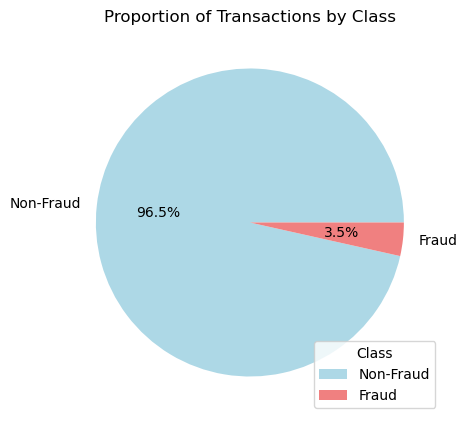

In [88]:
# Create a pie chart
class_counts = train_df['isFraud'].value_counts()

plt.figure(figsize=(8, 5))
plt.pie(class_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Transactions by Class')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='lower right')
plt.show()


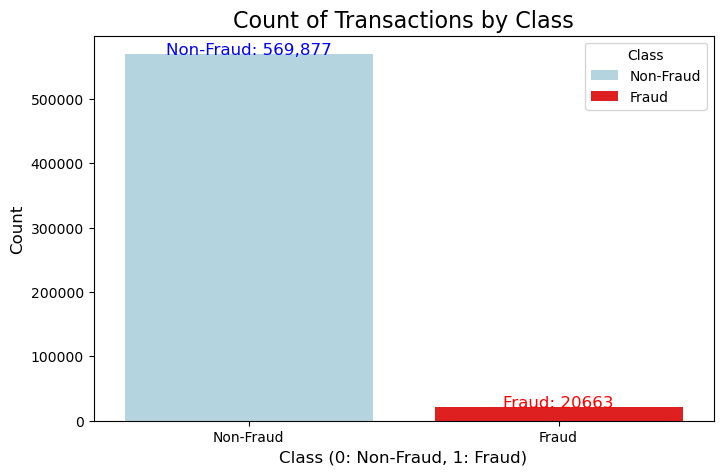

In [90]:
class_palette = {0: 'lightblue', 1: 'red'}

# Count plot for transactions
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='isFraud', data=train_df, hue='isFraud', palette=class_palette, order=train_df['isFraud'].value_counts().index)

# Get the counts for non-fraud and fraud
non_fraud_count = train_df['isFraud'].value_counts()[0]
fraud_count = train_df['isFraud'].value_counts()[1]

# Adding text annotations for counts with comma formatting
plt.text(0, non_fraud_count + 50, f'Non-Fraud: {non_fraud_count:,}', color='blue', fontsize=12, ha='center')
plt.text(1, fraud_count + 50, f'Fraud: {fraud_count}', color='red', fontsize=12, ha='center')

plt.title('Count of Transactions by Class', fontsize=16)
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='upper right')
plt.show()


In [106]:
# Convert categorical variables to dummy variables
train_df = pd.get_dummies(train_df, drop_first=True)

# Scale the data (important for neural networks)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df.drop(columns=['isFraud']))  # Exclude the target variable
scaled_df = pd.DataFrame(scaled_data, columns=train_df.drop(columns=['isFraud']).columns)

# Add back the target variable 'isFraud'
scaled_df['isFraud'] = train_df['isFraud'].values


# **Split Data**

In [93]:
# Split into normal (non-fraud) and fraudulent transactions
non_fraud = scaled_df[scaled_df['isFraud'] == 0].drop(columns=['isFraud'])
fraud = scaled_df[scaled_df['isFraud'] == 1].drop(columns=['isFraud'])

# Train-test split (using only non-fraud data for Autoencoder training)
X_train, X_test = train_test_split(non_fraud, test_size=0.2, random_state=42)

# Use some fraud data for validation/test, and normal transactions as well
X_test_with_fraud = pd.concat([X_test, fraud])

In [98]:
print(X_train.shape)
print(X_test.shape)

(455901, 609)
(113976, 609)


In [100]:
print(X_test_with_fraud.shape)

(134639, 609)


# **AutoEncoder Neural Network**


In [151]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, classification_report

# Define the Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 20  # You can adjust this size
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)

# Decoder
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder
history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=(X_test, X_test))


Epoch 1/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9140 - val_loss: 0.8376
Epoch 2/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8339 - val_loss: 0.8321
Epoch 3/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8393 - val_loss: 0.8298
Epoch 4/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8421 - val_loss: 0.8288
Epoch 5/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8400 - val_loss: 0.8280
Epoch 6/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8413 - val_loss: 0.8274
Epoch 7/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8383 - val_loss: 0.8263
Epoch 8/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8487 - val_loss: 0.8258
Epoch 9/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8473 - val_loss: 0.8253
Epoch 10/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8661 - val_loss: 0.8253
Epoch 11/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8331 - val_loss: 0.8249
Epoch 12/50
1781/1781 ━━━━━━━━

In [149]:
plt.plot(X_test[0],'b')

14

In [159]:
# Get reconstruction errors for the test data (normal and fraud)
reconstructions = autoencoder.predict(X_test_with_fraud)
reconstruction_error = np.mean(np.power(X_test_with_fraud - reconstructions, 2), axis=1)
reconstruction_error

4208/4208 ━━━━━━━━━━━━━━━━━━━━ 3s 713us/step


219206    0.233365
187783    1.511475
35892     0.063601
31989     0.138108
66086     0.284333
            ...   
590361    0.166233
590364    2.253694
590368    0.304146
590372    0.065692
590526    3.354945
Length: 134639, dtype: float64

In [161]:
threshold = np.percentile(reconstruction_error, 95)
threshold

3.5939205722418124

In [163]:
# Predict fraud based on reconstruction error
y_pred = [1 if e > threshold else 0 for e in reconstruction_error]

# Actual labels (fraud is 1, non-fraud is 0)
y_true = [1]*len(fraud) + [0]*len(X_test)

len(X_test)

113976

In [167]:
# Confusion Matrix and Classification Report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[107882   6094]
 [ 20025    638]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89    113976
           1       0.09      0.03      0.05     20663

    accuracy                           0.81    134639
   macro avg       0.47      0.49      0.47    134639
weighted avg       0.73      0.81      0.76    134639

